<a href="https://colab.research.google.com/github/isottongloria/PMLS_Bio-Learning/blob/main/scripts/Backpropagation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Unsupervised learning by competing hidden units

 ### **Author**

 - Gloria Isotton
 - Master degree in Physics of data


 ### **Introduction**

This notebook provides an accompanying implementation to test and evaluate a simple end-to-end model using traditional backpropagation, with the goal of comparing its performance to the biologically plausible learning algorithm explored in the previous notebook. In this case, we focus on a standard neural network architecture trained via backpropagation, which is the most widely used supervised learning method in modern deep learning.

The notebook walks through the process of implementing a basic feedforward neural network for classification on the same three datasets—CIFAR-10, MNIST, and Fashion MNIST—that were used in the bio-inspired learning model. We utilize a straightforward backpropagation algorithm to train the network, adjusting weights based on the gradient of the loss function with respect to the model's parameters. This is the standard approach for supervised learning and serves as a direct comparison to the biologically plausible method.

In [1]:
# Importing dependencies
# Execute on colab

import torch
import torchvision
from PIL import Image
from torch import nn,save,load
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split, TensorDataset
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
import numpy as np
import random
import os
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Dataset loading
Variable containing the dataset name `data_name`:
- `1` : MNIST https://pytorch.org/vision/stable/generated/torchvision.datasets.MNIST.html?ref=hackernoon.com#torchvision.datasets.MNIST <br>
- `2` : CIFAR10 https://pytorch.org/vision/stable/generated/torchvision.datasets.CIFAR10.html?ref=hackernoon.com#torchvision.datasets.CIFAR10<br>
- `3` : FashionMNIST https://pytorch.org/vision/stable/generated/torchvision.datasets.FashionMNIST.html?ref=hackernoon.com#torchvision.datasets.FashionMNIST<br>

In [ ]:
data_name=3

####### MNIST dataset ########
if data_name == 1:
    transform = transforms.Compose([transforms.ToTensor(),
                                   transforms.Lambda(lambda x: x.view(-1))])
    full_train_dataset = datasets.MNIST(root="data", download=True, train=True, transform=transform)

    train_size = 50000
    val_size = 10000
    train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=28, shuffle=True)
    test_loader = DataLoader(val_dataset, batch_size=28, shuffle=False)

    print(f"Training set size: {len(train_loader.dataset)}")
    print(f"Test set size: {len(test_loader.dataset)}")


####### CIFAR10 dataset ########
if data_name == 2:
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                                   transforms.Lambda(lambda x: x.view(-1))])
    full_train_dataset = datasets.CIFAR10(root="data", download=True, train=True, transform=transform)

    train_size = 40000
    val_size = 10000
    train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

    print(f"Training set size: {len(train_loader.dataset)}")
    print(f"Test set size: {len(test_loader.dataset)}")



####### FASHION MNIST dataset ########
if data_name == 3:
    transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,), (0.5,)),
                                   transforms.Lambda(lambda x: x.view(-1))])

    full_train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True,download=True, transform=transform)
    train_size = 10000
    val_size = 50000
    train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=28,shuffle=True)
    test_loader = torch.utils.data.DataLoader(val_dataset, batch_size=28,shuffle=False)

    print(f"Training set size: {len(train_loader.dataset)}")
    print(f"Test set size: {len(test_loader.dataset)}")



100%|██████████| 26.4M/26.4M [00:02<00:00, 11.7MB/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 211kB/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 3.92MB/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 6.48MB/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw

Training set size: 10000
Test set size: 50000


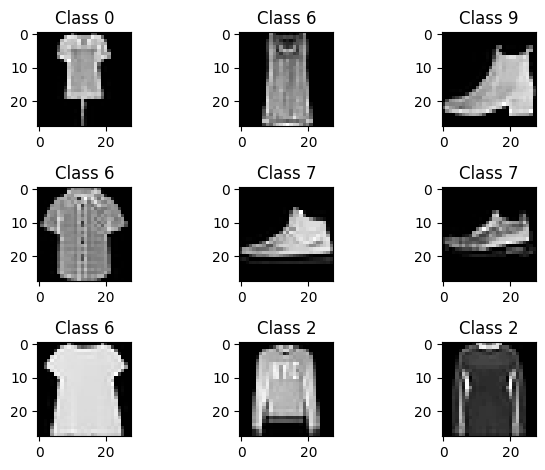

In [ ]:
# extract images and labels from training dataset for plotting
X_train = train_dataset.dataset.data
y_train = train_dataset.dataset.targets

for i in range(9):
    plt.subplot(3,3,i+1)
    num = random.randint(0, len(X_train))
    plt.imshow(X_train[num], cmap='gray', interpolation='none')
    plt.title("Class {}".format(y_train[num]))

plt.tight_layout()



# Backpropagation model

The model has 1 layer:
1. Input `x` is passed through the first fully connected layer (`FC1`).
2. The result is passed through the ReLU activation function.
3. Batch normalization is applied.
4. The batch-normalized data is passed through the second fully connected layer (`FC2`).
5. Finally, the output is passed through the softmax function to generate class probabilities.


In [ ]:
# Define the model class
class BPModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(BPModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.batch_norm = nn.BatchNorm1d(hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.batch_norm(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x

In [ ]:
### Parameters
num_epochs = 100
n_input = 784
n_hidden = 2000
batch_size = 28
learning_rate = 0.01
Kx = 10
Ky = 10
out_features = 10

# Create an instance of the image classifier model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
classifier = BPModel(n_input, n_hidden, out_features).to(device)

# Define the optimizer and loss function
optimizer = Adam(classifier.parameters(), lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

In [ ]:
classifier

BPModel(
  (fc1): Linear(in_features=784, out_features=2000, bias=True)
  (relu): ReLU()
  (batch_norm): BatchNorm1d(2000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=2000, out_features=10, bias=True)
  (softmax): Softmax(dim=1)
)

### Training

In [ ]:
### Training and Logging
train_loss_log = []
test_loss_log = []
test_accuracy_log = []  # To store test accuracy

### Training with Adam
for num_ep in range(num_epochs):

    # Training Loop (mini-batch training)
    classifier.train()  # Set model to training mode
    train_loss_vec = []  # Initialize list for training losses

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()  # Zero the parameter gradients
        output = classifier(images)  # Forward pass
        loss = loss_fn(output, labels)  # Compute loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights

        train_loss_vec.append(loss.item())  # Store loss for each mini-batch

    train_loss_log.append(np.mean(train_loss_vec))  # Store average loss for this epoch

    # Testing Loop (test set evaluation)
    classifier.eval()  # Set model to evaluation mode
    test_loss_vec = []
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            output = classifier(images)  # Forward pass
            loss = loss_fn(output, labels)  # Compute test loss
            test_loss_vec.append(loss.item())  # Store loss for each batch

            pred_label = output.argmax(dim=1)  # Get predicted labels
            correct += pred_label.eq(labels).sum().item()  # Count correct predictions
            total += labels.size(0)  # Total samples

    test_loss_log.append(np.mean(test_loss_vec))  # Store average test loss
    test_accuracy_log.append(100. * correct / total)  # Store test accuracy

    # Print epoch details
    print(f'Epoch {num_ep + 1}/{num_epochs} - Train loss: {np.mean(train_loss_log):.5f} - Test loss: {np.mean(test_loss_log):.5f} - Accuracy: {test_accuracy_log[-1]:.2f}%')


### Save the weights and the loss history

torch.save(classifier.state_dict(), f'{dataset_name}_bkpg_linear.pt')

np.savetxt(
   f'{dataset_name}_loss_train_bkpg_linear_hidden{n_hidden}.txt',
   train_loss_log
)

np.savetxt(
   f'{dataset_name}_loss_test_bkpg_linear_hidden{n_hidden}.txt',
   test_accuracy_log
)

Epoch 1/100 - Train loss: 1.88157 - Test loss: 1.81158 - Accuracy: 64.89%
Epoch 2/100 - Train loss: 1.86079 - Test loss: 1.81981 - Accuracy: 63.24%
Epoch 3/100 - Train loss: 1.85355 - Test loss: 1.82604 - Accuracy: 62.18%
Epoch 4/100 - Train loss: 1.84351 - Test loss: 1.81891 - Accuracy: 66.34%
Epoch 5/100 - Train loss: 1.83489 - Test loss: 1.81460 - Accuracy: 66.34%
Epoch 6/100 - Train loss: 1.82796 - Test loss: 1.81748 - Accuracy: 62.87%
Epoch 7/100 - Train loss: 1.82299 - Test loss: 1.81228 - Accuracy: 67.98%
Epoch 8/100 - Train loss: 1.81926 - Test loss: 1.80911 - Accuracy: 67.37%
Epoch 9/100 - Train loss: 1.81719 - Test loss: 1.80912 - Accuracy: 65.19%
Epoch 10/100 - Train loss: 1.81434 - Test loss: 1.80488 - Accuracy: 69.40%
Epoch 11/100 - Train loss: 1.81256 - Test loss: 1.80479 - Accuracy: 65.71%
Epoch 12/100 - Train loss: 1.81024 - Test loss: 1.80331 - Accuracy: 67.39%
Epoch 13/100 - Train loss: 1.80787 - Test loss: 1.79980 - Accuracy: 70.33%
Epoch 14/100 - Train loss: 1.80551

In [ ]:

### Save the weights and the loss history
dataset_name = 'FashionMNIST'
torch.save(classifier.state_dict(), f'{dataset_name}_bkpg_linear.pt')

np.savetxt(
   f'{dataset_name}_loss_train_bkpg_linear_hidden{n_hidden}.txt',
   train_loss_log
)

np.savetxt(
   f'{dataset_name}_loss_test_bkpg_linear_hidden{n_hidden}.txt',
   test_accuracy_log
)

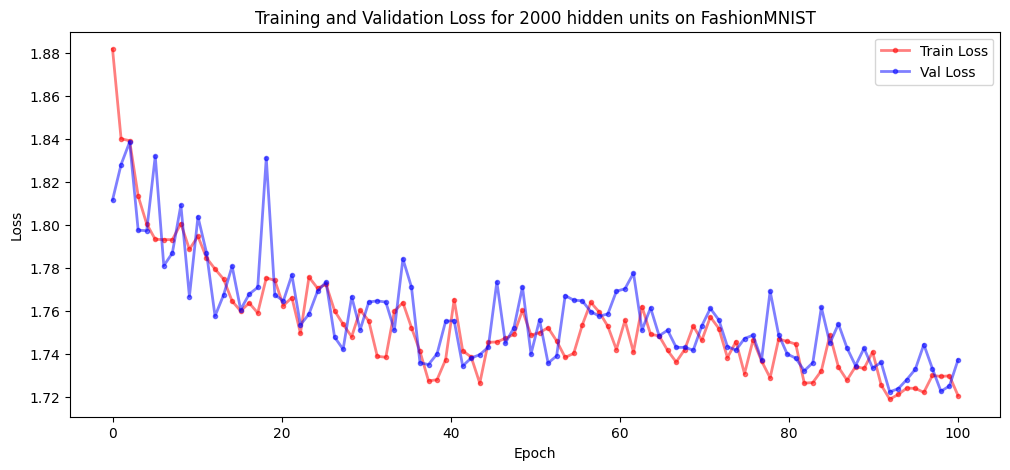

In [ ]:
# Plotting
# Dizionario dei nomi dei dataset
data_name_dict = {1: "MNIST", 2: "CIFAR10", 3: "FashionMNIST"}
dataset_name = data_name_dict.get(data_name, "UnknownDataset")

# Plot Loss
plt.figure(figsize=(12, 5))
plt.plot(np.linspace(0, len(test_loss_log), len(test_loss_log)), train_loss_log, '.-', label='Train Loss', color='red', lw=2, alpha=0.5)
plt.plot(np.linspace(0, len(test_loss_log), len(test_loss_log)), test_loss_log, '.-', label='Val Loss', color='blue', lw=2, alpha=0.5)
plt.title(f'Training and Validation Loss for {n_hidden} hidden units on {dataset_name}')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig(f'{dataset_name}_bkpg_{n_hidden}hu_{out_features}out_{num_epochs}ep_loss.png')
plt.show()


### Draw the weights of forst layer

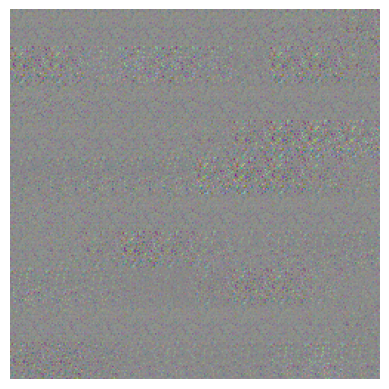

In [ ]:
def draw_weights(synapses, Kx, Ky, ax=None):
    # synapses: the weights
    Kw = int(np.sqrt(synapses.shape[1]//3)) # i.e. 32
    yy=0
    synapses = synapses.cpu()
    HM=np.zeros((Kw*Ky, Kw*Kx, 3))
    for y in range(Ky):
        for x in range(Kx):
            HM[y*Kw:(y+1)*Kw,x*Kw:(x+1)*Kw]=synapses[yy,:Kw*Kw*3].reshape(Kw, Kw, 3)
            yy += 1

    nc=np.amax(np.absolute(HM))
    tmp = (HM-HM.min())
    tmp /= tmp.max()
    tmp *= 255
    tmp = tmp.astype(np.uint8)
    if ax is not None:
        im = ax.imshow(tmp)
        ax.axis('off')
    else:
        plt.clf()
        im=plt.imshow(tmp.astype(np.uint8))
        plt.axis('off')
    fig.canvas.draw()

fig, ax_ = plt.subplots()
bp_weights = classifier.fc1.weight.data.T
bp_weights.shape
draw_weights(bp_weights, Kx=10, Ky=10)
plt.savefig(f'{dataset_name}_bkpg_fc1.png')